## Pose2Sim for triangulation

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Test torch installation
import torch; import onnxruntime as ort
print(torch.cuda.is_available(), ort.get_available_providers())
# Should print "True ['CUDAExecutionProvider', ...]"

from Pose2Sim import Pose2Sim

True ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [12]:
#copy Pose2Sim calibration file writing to go from matrices to Calib.toml
def toml_write(calib_path, C, S, D, K, R, T):
    '''
    Writes calibration parameters to a .toml file

    INPUTS:
    - calib_path: path to the output calibration file: string
    - C: camera name: list of strings
    - S: image size: list of list of floats
    - D: distorsion: list of arrays of floats
    - K: intrinsic parameters: list of 3x3 arrays of floats
    - R: extrinsic rotation: list of arrays of floats (Rodrigues)
    - T: extrinsic translation: list of arrays of floats

    OUTPUTS:
    - a .toml file cameras calibrations
    '''

    with open(os.path.join(calib_path), 'w+') as cal_f:
        for c in range(len(C)):
            cam=f'[{C[c]}]\n'
            name = f'name = "{C[c]}"\n'
            size = f'size = [ {S[c][0]}, {S[c][1]}]\n' 
            mat = f'matrix = [ [ {K[c][0,0]}, 0.0, {K[c][0,2]}], [ 0.0, {K[c][1,1]}, {K[c][1,2]}], [ 0.0, 0.0, 1.0]]\n'
            dist = f'distortions = [ {D[c][0]}, {D[c][1]}, {D[c][2]}, {D[c][3]}]\n' 
            rot = f'rotation = [ {R[c][0]}, {R[c][1]}, {R[c][2]}]\n'
            tran = f'translation = [ {T[c][0]}, {T[c][1]}, {T[c][2]}]\n'
            fish = f'fisheye = false\n\n'
            cal_f.write(cam + name + size + mat + dist + rot + tran + fish)
        meta = '[metadata]\nadjusted = false\nerror = 0.3\n'
        cal_f.write(meta)

C = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463']

H, W = 1920, 1080
S = [[H,W], [H,W], [H,W], [H,W], [H,W], [H,W], [H,W], [H,W]]

K = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_K_conf.npz')['arr_0']
D = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_D_conf.npz')['arr_0']

K = K.squeeze()
D = D.squeeze()

world_T_cam = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/WorldTCam_opt.npz')['arr_0']
extrinsics = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/Extrinsics_optimized_20250429_12h00.npz')['arr_0']

R = []
for r in extrinsics[:, 0:3, 0:3]:
    rot_vec = cv2.Rodrigues(r)[0]
    R.append(rot_vec)
R = np.asarray(R).squeeze()
T = extrinsics[:, 0:3, 3] / 1000

toml_write('Calibration/Calib.toml', C, S, D, K, R, T)

In [26]:
#Pose2Sim.poseEstimation()
#Pose2Sim.synchronization()
Pose2Sim.personAssociation()
Pose2Sim.triangulation()


---------------------------------------------------------------------
Associating persons for Pose2Sim, for all frames.
On Wednesday 04. June 2025, 11:55:20
Project directory: /home/lea/vitpose/Pose2Sim
---------------------------------------------------------------------


Multi-person analysis selected.
100%|██████████| 1045/1045 [00:08<00:00, 119.50it/s]

--> A person was reconstructed if the lines from cameras to their keypoints intersected within 0.1 m and if the calculated affinity stayed above 0.2 after excluding points with likelihood below 0.5.
--> Beware that people were sorted across cameras, but not across frames. This will be done in the triangulation stage.

Tracked json files are stored in /home/lea/vitpose/Pose2Sim/pose-associated.

Associating persons took 00h00m08s.


---------------------------------------------------------------------
Triangulation of 2D points for Pose2Sim, for all frames.
On Wednesday 04. June 2025, 11:55:29
Project directory: /home/lea/vitpose/P

0.3483041400040212 2.611056868184756 -1.0573172417851837 6.488933259368888


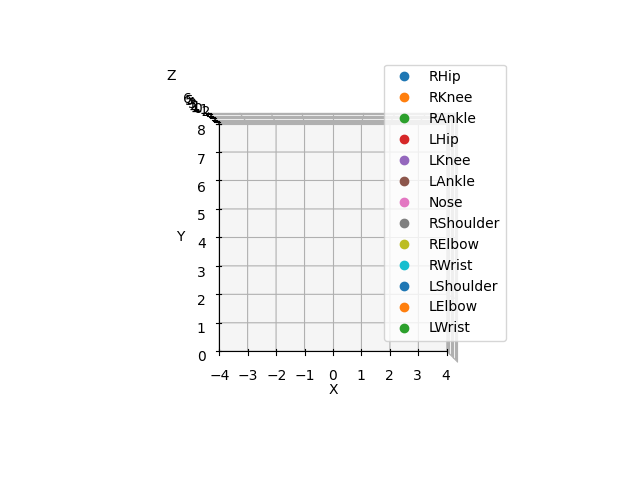

In [25]:
%matplotlib widget
# --- Load and parse .trc file ---
def load_trc(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # --- Metadata ---
    data_start_line = 5
    header_line = lines[3]
    header_parts = re.split(r'\s+', header_line.strip())
    
    marker_names = header_parts[2:]  # skip "Frame#" and "Time"
    n_markers = len(marker_names)
    
    # Reconstruct columns: Frame#, Time, then X/Y/Z for each marker
    cols = ['Frame#', 'Time']
    for name in marker_names:
        cols.append(f'{name}_X')
        cols.append(f'{name}_Y')
        cols.append(f'{name}_Z')

    # Read numerical data starting from line 6
    df = pd.read_csv(filename, sep=r'\s+|\t+', engine='python', skiprows=data_start_line, header=None)
    df.columns = cols

    return df, marker_names

def get_axis_limits(x_limits, y_limits, z_limits):
    # Find ranges and midpoints
    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]
    max_range = max(x_range, y_range, z_range)

    x_mid = sum(x_limits) / 2
    y_mid = sum(y_limits) / 2
    z_mid = sum(z_limits) / 2

    return x_mid, y_mid, z_mid, max_range

# --- Visualization ---
def animate_markers(df, marker_names, stride=5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    scatters = {}
    for name in marker_names:
        scatters[name], = ax.plot([], [], [], 'o', label=name)

    ax.view_init(elev=90, azim=-90)

    # Get min and max for each axis
    x_limits = df.filter(like='_X').values.min(), df.filter(like='_X').values.max()
    y_limits = df.filter(like='_Y').values.min(), df.filter(like='_Y').values.max()
    z_limits = df.filter(like='_Z').values.min(), df.filter(like='_Z').values.max()

    # Apply equal limits
    x_mid, y_mid, z_mid, max_range = get_axis_limits(x_limits, y_limits, z_limits)

    print(x_mid, y_mid, z_mid, max_range)

    #ax.set_xlim(x_mid - max_range/2, x_mid + max_range/2)
    #ax.set_ylim(y_mid - max_range/2, y_mid + max_range/2)
    #ax.set_zlim(z_mid - max_range/2, z_mid + max_range/2)

    ax.set_xlim(-4, 4)
    ax.set_ylim(0, 8)
    ax.set_zlim(-2, 6)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    def update(frame):
        for name in marker_names:
            x = df.loc[frame, f'{name}_X']
            y = df.loc[frame, f'{name}_Y']
            z = df.loc[frame, f'{name}_Z']
            scatters[name].set_data([x], [y])
            scatters[name].set_3d_properties([z])
        return scatters.values()

    ani = animation.FuncAnimation(fig, update, frames=range(0, len(df), stride), interval=50, blit=False)
    plt.show()

# --- Main ---
file_path = "/home/lea/vitpose/Pose2Sim/pose-3d/Pose2Sim_0-1044.trc"  # Replace with the actual path
df, marker_names = load_trc(file_path)
animate_markers(df, marker_names)


In [ ]:
def animate_skeleton(df, marker_names, connections, save_path='skeleton_animation.mp4'):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get initial joint positions
    joints = {name: ax.plot([], [], [], 'o')[0] for name in marker_names}
    bones = [ax.plot([], [], [], 'black')[0] for _ in connections]

    def init():
        ax.view_init(elev=90, azim=-90)

        # Get min and max for each axis
        x_limits = df.filter(like='_X').values.min(), df.filter(like='_X').values.max()
        y_limits = df.filter(like='_Y').values.min(), df.filter(like='_Y').values.max()
        z_limits = df.filter(like='_Z').values.min(), df.filter(like='_Z').values.max()

        # Apply equal limits
        x_mid, y_mid, z_mid, max_range = get_axis_limits(x_limits, y_limits, z_limits)
        ax.set_xlim(x_mid - max_range/2, x_mid + max_range/2)
        ax.set_ylim(y_mid - max_range/2, y_mid + max_range/2)
        ax.set_zlim(z_mid - max_range/2, z_mid + max_range/2)
    
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        return list(joints.values()) + bones

    def update(frame):
        for name in marker_names:
            x = df.loc[frame, f'{name}_X']
            y = df.loc[frame, f'{name}_Y']
            z = df.loc[frame, f'{name}_Z']
            joints[name].set_data([x], [y])
            joints[name].set_3d_properties([z])

        for i, (a, b) in enumerate(connections):
            x = [df.loc[frame, f'{a}_X'], df.loc[frame, f'{b}_X']]
            y = [df.loc[frame, f'{a}_Y'], df.loc[frame, f'{b}_Y']]
            z = [df.loc[frame, f'{a}_Z'], df.loc[frame, f'{b}_Z']]
            bones[i].set_data(x, y)
            bones[i].set_3d_properties(z)

        return list(joints.values()) + bones

    anim = FuncAnimation(fig, update, frames=range(0, len(df), 4), init_func=init, blit=True)

    print("Saving animation...")
    writer = FFMpegWriter(fps=30, metadata=dict(artist='Pose2Sim'), bitrate=1800)
    anim.save(save_path, writer=writer)
    print(f"Saved to: {save_path}")

    plt.close(fig)

# --- Main ---
file_path = "pose-3d/Pose2Sim_5-1684.trc"
df, marker_names = load_trc(file_path)

# Define skeleton structure (example — adjust as needed)
connections = [
    ('RHip', 'RKnee'), ('RKnee', 'RAnkle'),
    ('LHip', 'LKnee'), ('LKnee', 'LAnkle'),
    ('RHip', 'LHip'), ('RHip', 'RShoulder'), ('LHip', 'LShoulder'),
    ('RShoulder', 'RElbow'), ('RElbow', 'RWrist'),
    ('LShoulder', 'LElbow'), ('LElbow', 'LWrist'),
    ('RShoulder', 'LShoulder'), ('Nose', 'RShoulder'), ('Nose', 'LShoulder')
]

animate_skeleton(df, marker_names, connections, save_path='pose_skeleton.mp4')
plt.close()


/tmp/ipykernel_105873/1084496824.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))


Saving animation...
Saved to: pose_skeleton.mp4
